In [1]:
import sys
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from pandas.plotting import scatter_matrix
import scipy
import scipy.stats as stats
from scipy.stats import loguniform
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler, RobustScaler, PowerTransformer, PolynomialFeatures
from sklearn.compose import ColumnTransformer, TransformedTargetRegressor
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.linear_model import LinearRegression, SGDRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.decomposition import LatentDirichletAllocation
import regex as re
import string  
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')
from itertools import chain
import gensim.downloader as gensim_api
import gensim

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/animadurkar/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/animadurkar/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/animadurkar/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [2]:
stop_wrds = stopwords.words("english")
lem = WordNetLemmatizer()

In [3]:
def topnevals_bar(df, dimension, n = None):
    if dimension == 'score':
        bin_df = df.copy()
        bin_df['binned'] = bin_df[dimension].apply(lambda x: int(x))
        fig, ax = plt.subplots(figsize=(12,6))
        plt.rcParams.update({'font.size': 12})
        ax = sns.countplot(data=bin_df, x="binned")
        ax.set(xlabel="Score", title="Value Counts of Binned Score")
        plt.show()
    else:
        sorted_dict = df[dimension].value_counts().to_dict()
        tup_list = sorted(sorted_dict.items(), key=lambda x:x[1], reverse=True)
        print("Total {}s found: {}".format(dimension, len(tup_list)))

        df = pd.DataFrame(tup_list[:n], columns=[dimension, 'count'])
        if n != None:
            t = f"Top {n} {dimension} by Count of Evaluations"
        else:
            t = f"All {dimension}s by Count of Evaluations"

        fig, ax = plt.subplots(figsize=(12,6))
        plt.rcParams.update({'font.size': 12})
        ax = sns.barplot(x="count", y=dimension, data=df, palette='GnBu_d')
        ax.set(xlabel="count", ylabel=dimension, title=t)
        plt.show()

In [4]:
def topscore_dim(df, dim):
    bin_df = df.copy()
    if dim == 'Division':
        sorted_dict = bin_df[dim].value_counts().to_dict()
        tup_list = sorted(sorted_dict.items(), key=lambda x:x[1], reverse=True)
        top_divisions = [x[0] for x in tup_list[:10]]
        bin_df = bin_df[bin_df[dim].isin(top_divisions)]
    bin_df['binned'] = bin_df['score'].apply(lambda x: int(x))
    grouped = bin_df.groupby([dim, 'binned']).size().unstack(level=-1).fillna(0)
    fig, ax = plt.subplots(figsize=(12.5,12))
    plt.rcParams.update({'font.size': 12})
    ax = sns.heatmap(grouped, cmap = sns.cm.rocket_r, cbar_kws={'shrink':.9 }, linewidths=.3, linecolor='white')
    bottom, top = ax.get_ylim()
    ax.set_ylim(bottom + 0.5, top - 0.5)
    ax.set(xlabel="binned score", title="Heatmap of Scores by Top 10 {}s".format(dim))
    plt.show()

In [5]:
def num_dist(df, x):
    fig, ax = plt.subplots(figsize=(25,6))
    plt.rcParams.update({'font.size': 12})
    ax = sns.histplot(data=df, x=x, kde=True)
    ax.set(xlabel=x, title="Distribution of {}".format(x))
    plt.show()

In [6]:
def correlation_heatmap(df):
    fig, ax = plt.subplots(figsize=(12.5,12))
    colormap = sns.diverging_palette(220, 10, as_cmap = True)
    plt.rcParams.update({'font.size': 12})
    ax = sns.heatmap(df.corr(), cmap=colormap, cbar_kws={'shrink':.9 }, annot=True, vmin=-1, vmax=1, linecolor='white', annot_kws={'fontsize':12 })
    bottom, top = ax.get_ylim()
    ax.set_ylim(bottom + 0.5, top - 0.5)
    ax.set(title="Pearson Correlation of Features")
    plt.show()

In [7]:
def splomchart(df):

    num_attribs = ['score', 'char_count', 'avg_word_length', 'avg_sentence_length', 'caps_vs_length']
    fig = sns.pairplot(df[num_attribs], diag_kind="kde", corner=True)
    plt.show()

In [8]:
def score_scatter(df, x):
    fig, ax = plt.subplots(figsize=(25,6))
    plt.rcParams.update({'font.size': 12})
    ax = sns.scatterplot(x=x, y='score', hue='score', data=df)
    ax.set(xlabel=x, ylabel="Score", title="Score and {} Plot".format(x))
    plt.show()

In [9]:
def top_ngrams(df, n=10, tri = False):

    corpus = df['text_clean'].apply(lambda x: str(x).lower().split())
    lst_tokens = list(chain.from_iterable(corpus.values))

    if tri:
        fig, ax = plt.subplots(figsize=(25,6))
        ## trigrams
        dic_bi_freq = nltk.FreqDist(nltk.ngrams(lst_tokens, 3))
        trigrams = pd.DataFrame(dic_bi_freq.most_common(), columns=["Word","Freq"])
        trigrams["Word"] = trigrams["Word"].apply(lambda x: " ".join(string for string in x) )
        trigrams.set_index("Word").iloc[:n,:].sort_values(by="Freq") \
            .plot(kind="barh", title="Trigrams", ax=ax, legend=False) \
                .grid(axis='x')
        ax.set(ylabel=None)
        plt.show()
    else:            
        fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(25,6))
        fig.suptitle("Most Frequent Words", fontsize=15)
        ## unigrams
        dic_uni_freq = nltk.FreqDist(lst_tokens)
        unigrams = pd.DataFrame(dic_uni_freq.most_common(), columns=["Word","Freq"])
        unigrams.set_index("Word").iloc[:n,:].sort_values(by="Freq") \
            .plot(kind="barh", title="Unigrams", ax=ax[0], legend=False) \
                .grid(axis='x')
        ax[0].set(ylabel=None)

        ## bigrams
        dic_bi_freq = nltk.FreqDist(nltk.ngrams(lst_tokens, 2))
        bigrams = pd.DataFrame(dic_bi_freq.most_common(), columns=["Word","Freq"])
        bigrams["Word"] = bigrams["Word"].apply(lambda x: " ".join(string for string in x) )
        bigrams.set_index("Word").iloc[:n,:].sort_values(by="Freq") \
            .plot(kind="barh", title="Bigrams", ax=ax[1], legend=False) \
                .grid(axis='x')
        ax[1].set(ylabel=None)
        plt.show()

In [10]:
def normalize_text(txt):
    #stripping and lowering extracted words
    txt_clean_first = re.sub(r'\[(.*?)\]', '', str(txt))
    txt_clean = re.sub(r'[^a-zA-Z\s]', '', str(txt_clean_first).lower().strip())
    txt_clean_split = txt_clean.split()
    #taking out stop words from words list
    txt_clean_split_nostop = [word for word in txt_clean_split if word not in stop_wrds]
    #lemmatizing words from list
    txt_clean_split_nostop_lem = [lem.lemmatize(word) for word in txt_clean_split_nostop]
    #joining back into sentence
    text = " ".join(txt_clean_split_nostop_lem)

    return text

def create_num_features(df):
    newdf = df.copy()
    
    newdf['word_count'] = newdf["Comment.Text.Processed"].apply(lambda x: len(str(x).split(" ")))
    newdf['char_count'] = newdf["Comment.Text.Processed"].apply(lambda x: sum(len(word) for word in str(x).split(" ")))
    newdf['sentence_count'] = newdf["Comment.Text.Processed"].apply(lambda x: len(str(x).split(".")))
    newdf['avg_word_length'] = newdf['char_count'] / newdf['word_count']
    newdf['avg_sentence_length'] = newdf['word_count'] / newdf['sentence_count']
    newdf['capitals'] = newdf['Comment.Text.Processed'].apply(lambda comment: sum(1 for c in comment if c.isupper()))
    newdf['caps_vs_length'] = newdf.apply(lambda row: float(row['capitals'])/float(row['sentence_count']),axis=1)
#     newdf['num_unique_words'] = newdf['Comment.Text.Processed'].apply(lambda x: len(set(w for w in x.split())))
#     newdf["word_unique_percent"] =  newdf["num_unique_words"]*100/newdf['word_count']
    
    return newdf

In [11]:
def read_files():
    
    eval_demog_df = pd.read_csv('course_evaluation_with_demographics.csv')
    train_val_df = pd.read_csv('course_evaluation_without_demographics_TRAINING.csv')
    test_df = pd.read_csv('course_evaluation_without_demographics_TEST.csv')
    
    #dropping Nans
    train_val_df.dropna(inplace=True)
    
    #Lemmatizing and Cleaning free text
    train_val_df["text_clean"] = train_val_df["Comment.Text.Processed"].apply(lambda x: normalize_text(x))
    test_df["text_clean"] = test_df["Comment.Text.Processed"].apply(lambda x: normalize_text(x))
    
    #Creating numerical features
    train_val_df = create_num_features(train_val_df)
    test_df = create_num_features(test_df)
    
    train_val_df = train_val_df.drop(columns=['word_count', 'sentence_count', 'capitals'])
    test_df = test_df.drop(columns=['word_count', 'sentence_count', 'capitals'])
    
    #removing outliers and fixing 0s
    train_val_df = train_val_df[~train_val_df['char_count'] < 10]
    train_val_df = train_val_df[~train_val_df.index.isin(train_val_df[train_val_df['text_clean'] == ''].index)]
    
    train_val_df = train_val_df[~(train_val_df['score'] == 0)]
#     train_val_df.loc[train_val_df['score'] == 0, 'score'] = 1
    
    return eval_demog_df, train_val_df, test_df

def read_sample_sub():
    
    sample_sub = pd.read_csv('sampleSubmission.csv')
    
    return sample_sub


In [12]:
def model(model, X_train, X_test, y_train, y_test, test, gs = False, params = None):
    
    test_df = test.drop(columns=['id'])
    n_pipe = Pipeline([("robust", RobustScaler()),
                       ("power", PowerTransformer(standardize=True))])


    pipe = ([("num", n_pipe, num_features),
          ("cat", OneHotEncoder(categories='auto', handle_unknown='ignore'), cat_features),
          ("txt", TfidfVectorizer(stop_words='english', ngram_range=(1,2), max_features=25000, 
                                  use_idf=False, norm='l2'), txt_features)])
    col_transform = ColumnTransformer(transformers=pipe)
    
    X_train = col_transform.fit_transform(X_train).toarray()
    X_test = col_transform.transform(X_test).toarray()
    test = col_transform.transform(test_df).toarray()    
#     reg_pipeline = Pipeline(steps=[('prep',col_transform), ('model', model)])

    reg_model = TransformedTargetRegressor(regressor=model, transformer=PowerTransformer(standardize=True))
    
    if gs:
        reg_model = GridSearchCV(reg_model, params, n_jobs=-1)
        
    reg_model = reg_model.fit(X_train, y_train)
    y_pred = reg_model.predict(X_test)
    
    test_final = reg_model.predict(test)
    
    return reg_model, y_pred, test_final, col_transform
    

In [13]:
eval_demog_df, train_val_df, test_df = read_files()    
sample_sub = read_sample_sub()

In [14]:
train_val_df.head()

,score,Division,Type,Comment.Text.Processed,text_clean,char_count,avg_word_length,avg_sentence_length,caps_vs_length
0,4.25,MEMS,LEC,I was very eager to take this course because o...,eager take course enthusiasm subject disregard...,2713,4.354735,17.800000,0.914286
1,4.25,MEMS,DIS,"[--] was a great GSI , very open and very well...",great gsi open well organized helpful friendly...,242,4.321429,11.200000,0.600000
2,4.20,HISTORY,DIS,The GSI did his best to help us understand the...,gsi best help u understand material covered le...,228,4.560000,12.500000,2.250000
3,4.00,HISTORY,DIS,The discussion sessions were enthusiastic and ...,discussion session enthusiastic helped develop...,620,4.428571,12.727273,1.181818
4,4.13,MEMS,DIS,[--] some interesting insights on course mater...,interesting insight course material slight are...,476,4.407407,15.428571,0.571429


In [15]:
train_val_df.isna().sum()

score                     0
Division                  0
Type                      0
Comment.Text.Processed    0
text_clean                0
char_count                0
avg_word_length           0
avg_sentence_length       0
caps_vs_length            0
dtype: int64

['MEMS' 'HISTORY' 'HONORS' 'ITALIAN' 'PHIL' 'POLSCI' 'PSYCH' 'REES'
 'SLAVIC' 'SPANISH' 'HBEHED' 'RCIDIV' 'CAAS' 'ENGLISH' 'LING' 'MATH'
 'MENAS' 'DANCE' 'BIOSTAT' 'HMP' 'SW' 'AMCULT' 'MECHENG' 'ANTHRBIO' 'ELI'
 'AEROSP' 'PHARMSCI' 'THEORY' 'EECS' 'CHE' 'MATSCIE' 'SAC' 'ECON' 'RCHUMS'
 'BIOMEDE' 'IOE' 'ANTHRCUL' 'FRENCH' 'HISTART' 'PUBPOL' 'RCSSCI' 'MUSED'
 'EDUC' 'APPPHYS' 'CEE' 'ENS' 'NRE' 'EHS' 'RCCORE' 'RCARTS' 'UC' 'MCDB'
 'HJCS' 'EPID' 'TCHNCLCM' 'ENGR' 'WOMENSTD' 'VOICE' 'NURS' 'NAVARCH'
 'ROMLING' 'MOVESCI' 'SM' 'PHYSED' 'KINESLGY' 'VOICELIT' 'ACABS' 'ASTRO'
 'BIOLOGY' 'RUSSIAN' 'EEB' 'GEOSCI' 'JAZZ' 'ENVIRON' 'CHEM' 'RELIGION'
 'STATS' 'THTREMUS' 'ANTHRARC' 'AAPTIS' 'AOSS' 'GERMAN' 'MUSICOL' 'CSP'
 'SOC' 'ENSCEN' 'BIOLCHEM' 'PHYSICS' 'OPERA' 'ARCH' 'LACS' 'CMPLXSYS'
 'JUDAIC' 'AT' 'ASIAN' 'MFG' 'NERS' 'PORTUG' 'NEUROSCI' 'COMM' 'LAW'
 'RCLANG' 'ORGSTUDY' 'POLISH' 'ARTDES' 'SOCADMIN' 'ASIANLAN' 'SI'
 'CHEMBIO' 'CICS' 'MACROMOL' 'NAVSCI' 'DUTCH' 'MEDADM' 'MEDCHEM' 'UP'
 'CZECH' 

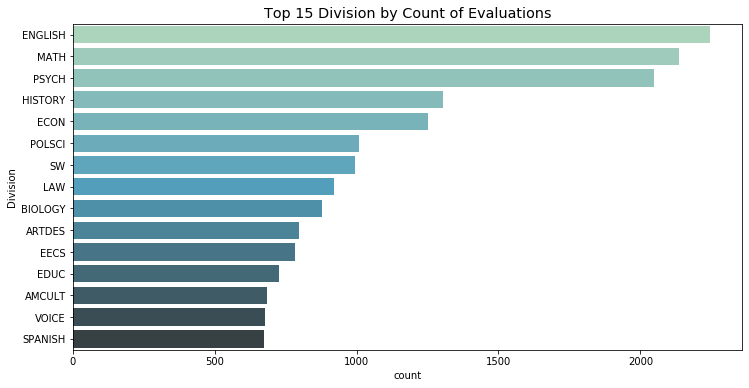

In [16]:
print(train_val_df['Division'].unique())
topnevals_bar(train_val_df, 'Division', 15)

['LEC' 'DIS' 'SEM' 'REC' 'LAB' 'IND' 'SMA' 'CLN' 'PSI' 'RES']
Total Types found: 10


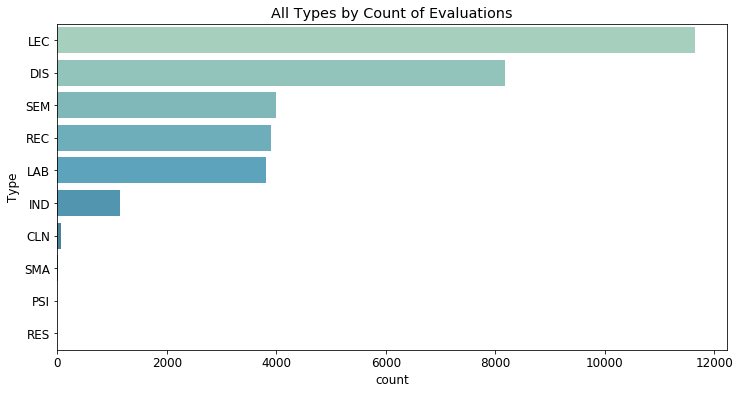

In [17]:
print(train_val_df['Type'].unique())
topnevals_bar(train_val_df, 'Type')

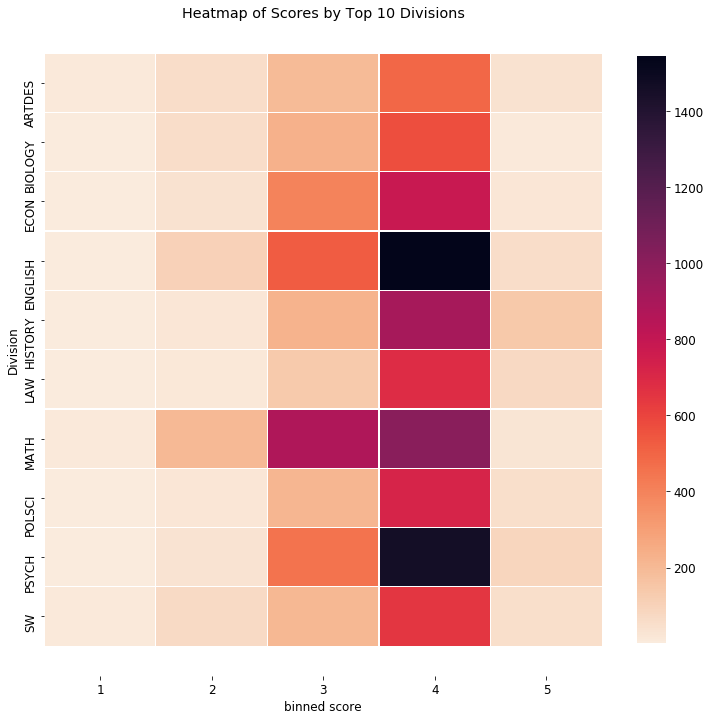

In [18]:
topscore_dim(train_val_df, 'Division')

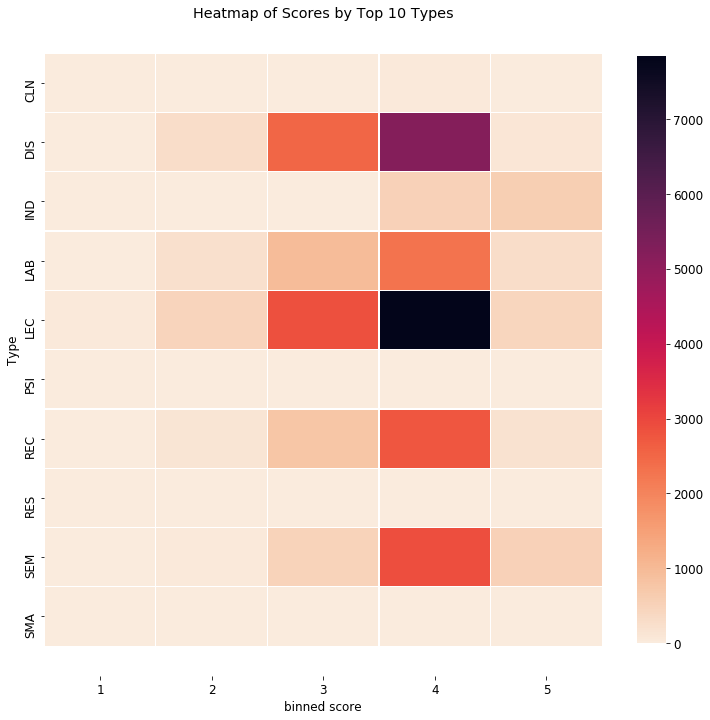

In [19]:
topscore_dim(train_val_df, 'Type')

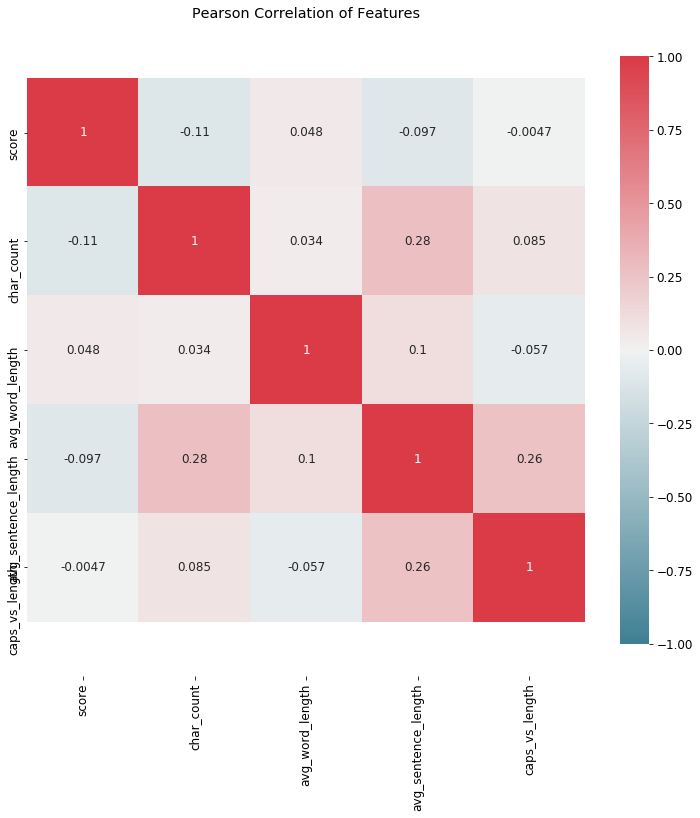

In [20]:
correlation_heatmap(train_val_df)

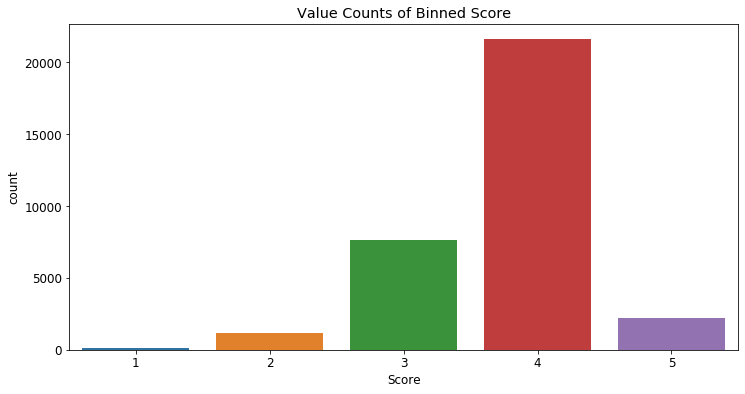

In [21]:
topnevals_bar(train_val_df, 'score')

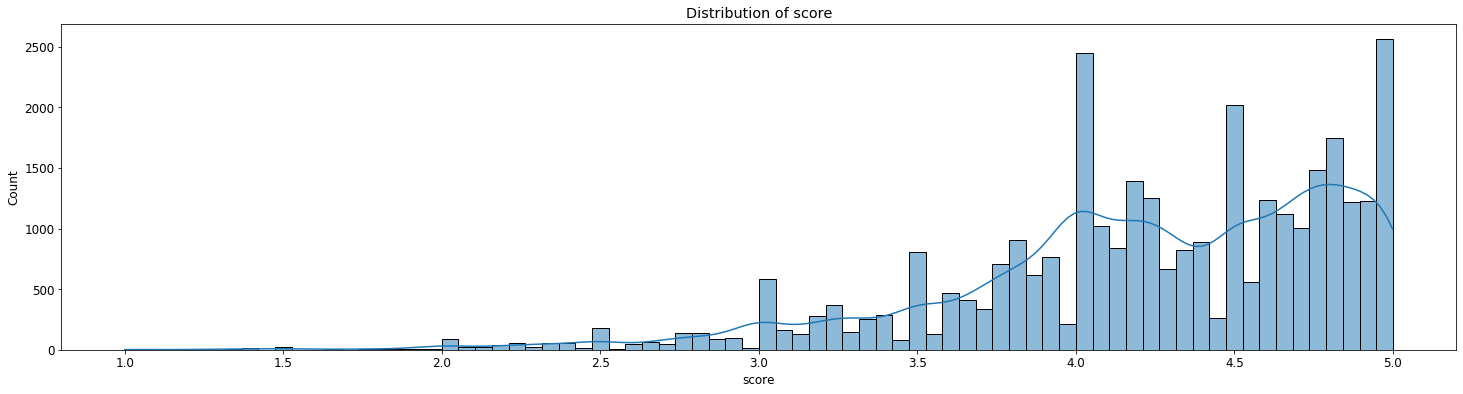

In [22]:
num_dist(train_val_df, 'score')

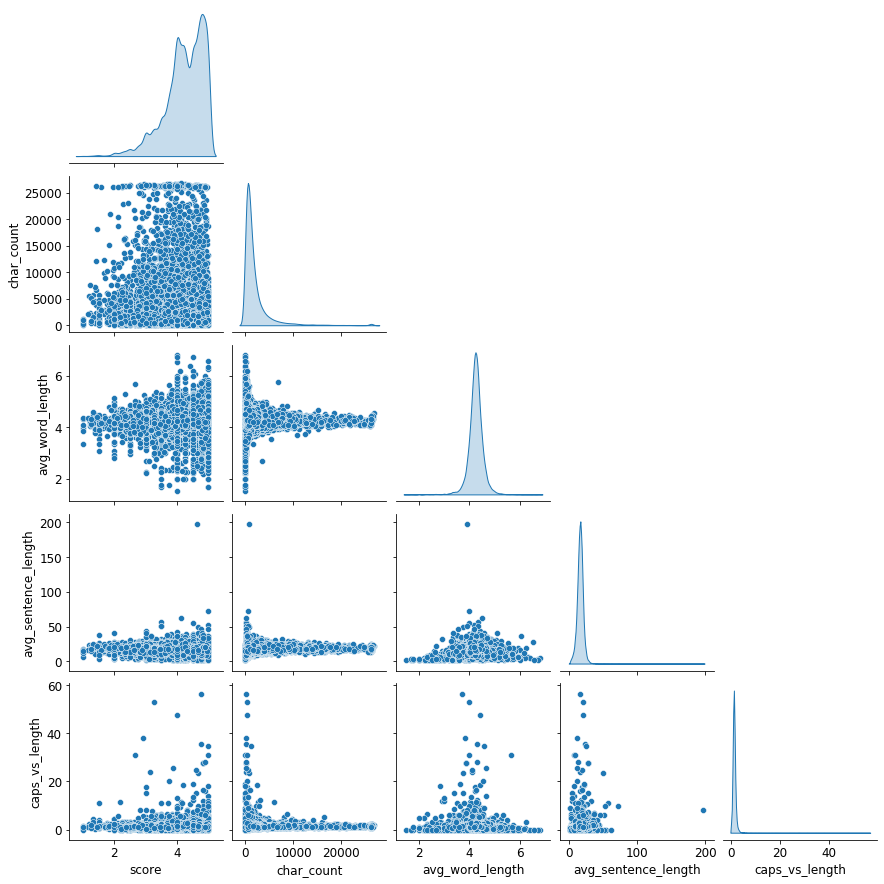

In [23]:
splomchart(train_val_df)

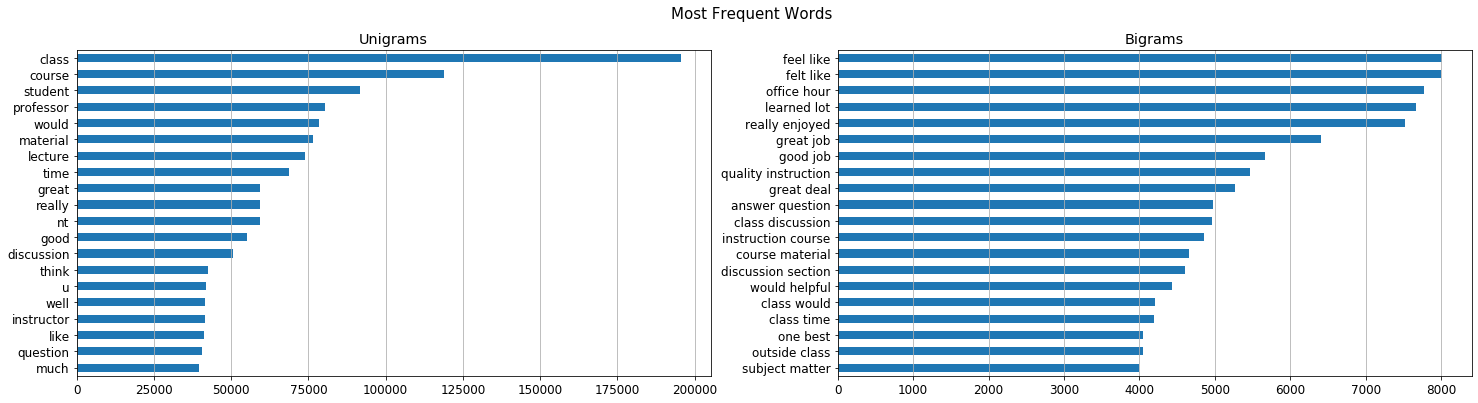

In [24]:
top_ngrams(train_val_df, 20)

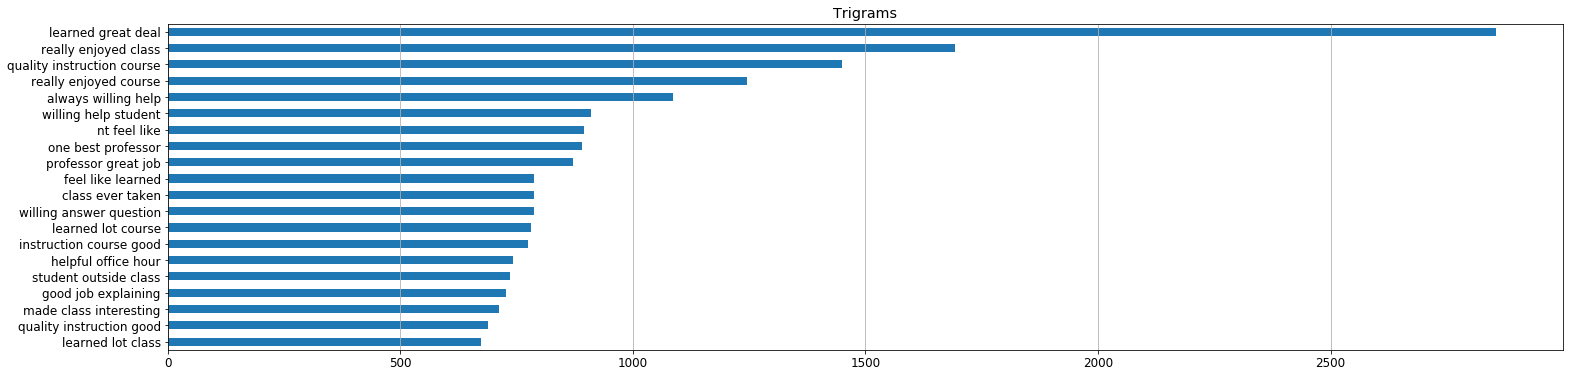

In [25]:
top_ngrams(train_val_df, 20, tri=True)

In [27]:
RANDOM_SEED = 42
y = train_val_df.score
X = train_val_df.drop(columns=['score'])
test_fin = test_df.drop(columns=['score']).dropna()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)


In [33]:
cat_features = ['Division', 'Type']
txt_features = 'text_clean'
num_features = ['char_count', 'avg_word_length', 'avg_sentence_length', 'caps_vs_length']

all_features = num_features + cat_features + [txt_features]


In [34]:
#Initialize basic linear models & CV variants
lr_model = SGDRegressor(penalty='elasticnet', l1_ratio=.05, alpha=1e-05, learning_rate='adaptive', 
                         validation_fraction=.1,early_stopping=True, random_state=RANDOM_SEED, shuffle=True)

lr_cv_model = SGDRegressor(penalty='elasticnet', learning_rate='adaptive', validation_fraction=.1, 
                        early_stopping=True, random_state=RANDOM_SEED, shuffle=True)

svm_model = SGDRegressor(loss="epsilon_insensitive", penalty='elasticnet', epsilon=1e-04,
                         learning_rate='adaptive', validation_fraction=.1,
                         early_stopping=True, random_state=RANDOM_SEED, shuffle=True)

svm_cv_model = SGDRegressor(loss="epsilon_insensitive", penalty='elasticnet',
                            learning_rate='adaptive', validation_fraction=.1,
                            early_stopping=True, random_state=RANDOM_SEED, shuffle=True)


dt_model = DecisionTreeRegressor(random_state=RANDOM_SEED)

rf_model = RandomForestRegressor(n_estimators=200, max_depth=2, bootstrap=True, random_state=RANDOM_SEED)



In [35]:
lr_cv_params = [{'regressor__l1_ratio': [.05, .15, .5, .7, .9, .95],
                 'regressor__alpha': 10.0**-np.arange(1,7),
                 'regressor__eta0': 10.0**-np.arange(1,4)}]


rf_cv_params = [{'regressor__n_estimators': [50, 100, 150, 200], 
                 'regressor__max_depth': [2, 4, 6, 8]}]

In [36]:
lr_model_fitted, lr_y_pred, test_final, col_transform = model(lr_model, X_train, X_test, y_train, y_test, test_fin)

In [37]:
mean_squared_error(y_test, lr_y_pred)

0.23957427454722274

In [38]:
lr_model_fitted.get_params()

{'check_inverse': True,
 'func': None,
 'inverse_func': None,
 'regressor__alpha': 1e-05,
 'regressor__average': False,
 'regressor__early_stopping': True,
 'regressor__epsilon': 0.1,
 'regressor__eta0': 0.01,
 'regressor__fit_intercept': True,
 'regressor__l1_ratio': 0.05,
 'regressor__learning_rate': 'adaptive',
 'regressor__loss': 'squared_loss',
 'regressor__max_iter': 1000,
 'regressor__n_iter_no_change': 5,
 'regressor__penalty': 'elasticnet',
 'regressor__power_t': 0.25,
 'regressor__random_state': 42,
 'regressor__shuffle': True,
 'regressor__tol': 0.001,
 'regressor__validation_fraction': 0.1,
 'regressor__verbose': 0,
 'regressor__warm_start': False,
 'regressor': SGDRegressor(alpha=1e-05, average=False, early_stopping=True, epsilon=0.1,
              eta0=0.01, fit_intercept=True, l1_ratio=0.05,
              learning_rate='adaptive', loss='squared_loss', max_iter=1000,
              n_iter_no_change=5, penalty='elasticnet', power_t=0.25,
              random_state=42, shuff

In [38]:
# lr_gs_model, lr_gs_y_pred, lr_gs_test_final = model(lr_cv_model, X_train, X_test, y_train, y_test, test_fin, 
#                                                     gs=True, params=lr_cv_params)

In [39]:
# print("# Tuning hyper-parameters for MSE")
# print()
# print("Best parameters set found on development set:")
# print()
# print(lr_gs_model.best_params_)
# print()
# print("Grid scores on development set:")
# print()
# means = lr_gs_model.cv_results_['mean_test_score']
# stds = lr_gs_model.cv_results_['std_test_score']
# for mean, std, params in zip(means, stds, lr_gs_model.cv_results_['params']):
#     print("%0.3f (+/-%0.03f) for %r"
#           % (mean, std * 2, params))
# print()

In [33]:
n_pipe = Pipeline([("robust", RobustScaler()),
                   ("power", PowerTransformer(standardize=True))])

tfidfdict = {}
for n in [5000, 10000, 15000, 20000, 25000]:
    pipe = ([("num", n_pipe, num_features),
          ("cat", OneHotEncoder(categories='auto', handle_unknown='ignore'), cat_features),
          ("txt", TfidfVectorizer(stop_words='english', ngram_range=(1,2), max_features=n, 
                                  use_idf=False, norm='l2'), txt_features)])
    col_transform = ColumnTransformer(transformers=pipe)
    
    new_X_train = col_transform.fit_transform(X_train).toarray()
    new_X_test = col_transform.transform(X_test).toarray()


    new_reg_model = TransformedTargetRegressor(regressor=lr_model, transformer=PowerTransformer(standardize=True))
    
        
    new_reg_model = new_reg_model.fit(new_X_train, y_train)
    new_y_pred_train = new_reg_model.predict(new_X_train)
    new_y_pred = new_reg_model.predict(new_X_test)
    
    tfidfdict[n] = [mean_squared_error(y_train, new_y_pred_train), mean_squared_error(y_test, new_y_pred)]

In [35]:
for m in [.05, .15, .25, .35, .5]:
    pipe = ([("num", n_pipe, num_features),
          ("cat", OneHotEncoder(categories='auto', handle_unknown='ignore'), cat_features),
          ("txt", TfidfVectorizer(stop_words='english', ngram_range=(1,2), min_df=m, 
                                  use_idf=False, norm='l2'), txt_features)])
    col_transform = ColumnTransformer(transformers=pipe)
    
    new_X_train = col_transform.fit_transform(X_train).toarray()
    new_X_test = col_transform.transform(X_test).toarray()


    new_reg_model = TransformedTargetRegressor(regressor=lr_model, transformer=PowerTransformer(standardize=True))
    
        
    new_reg_model = new_reg_model.fit(new_X_train, y_train)
    new_y_pred_train = new_reg_model.predict(new_X_train)
    new_y_pred = new_reg_model.predict(new_X_test)
    
    tfidfdict[m] = [mean_squared_error(y_train, new_y_pred_train), mean_squared_error(y_test, new_y_pred)]

In [61]:
tfidfdict

{5000: [0.22932913643444527, 0.23978706017445964],
 10000: [0.22755399960322145, 0.23964220801187838],
 15000: [0.22678905002425945, 0.23955639653391014],
 20000: [0.22635082655483216, 0.23957142411974436],
 25000: [0.22604060416052785, 0.23957427454722346],
 0.05: [0.24814070057555873, 0.2513630714752143],
 0.15: [0.2765561997292215, 0.2768902473681717],
 0.25: [0.28443137560449056, 0.28424128771585133],
 0.35: [0.29678703998354106, 0.29673386223390236],
 0.5: [0.3115516404337803, 0.3103648751603364]}

In [69]:
tfidf_gs_df = pd.DataFrame.from_dict(tfidfdict, orient='index', columns=['training_MSE', 'validation_MSE']) \
                                    .reset_index().rename(columns={'index':'x'})
tfidf_gs_df

,x,training_MSE,validation_MSE
0,5000.00,0.229329,0.239787
1,10000.00,0.227554,0.239642
2,15000.00,0.226789,0.239556
3,20000.00,0.226351,0.239571
4,25000.00,0.226041,0.239574
5,0.05,0.248141,0.251363
6,0.15,0.276556,0.276890
7,0.25,0.284431,0.284241
8,0.35,0.296787,0.296734
9,0.50,0.311552,0.310365


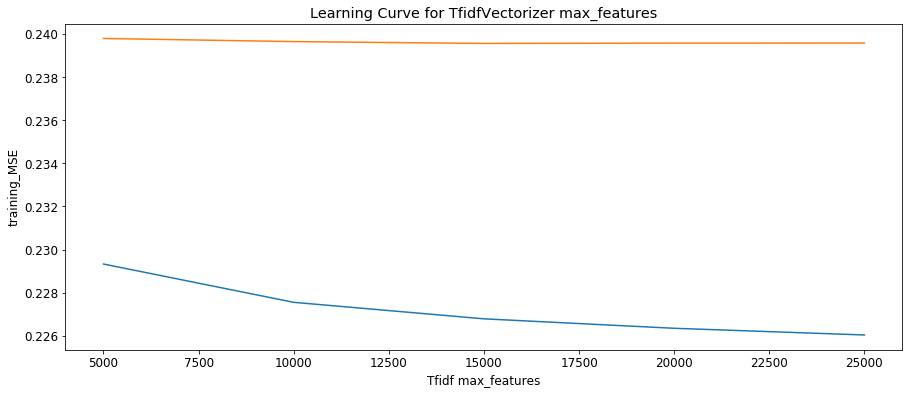

In [72]:
fig, ax = plt.subplots(figsize=(15,6))
plt.rcParams.update({'font.size': 12})
ax = sns.lineplot(x=tfidf_gs_df.x[:5], y=tfidf_gs_df.training_MSE[:5])
ax = sns.lineplot(x=tfidf_gs_df.x[:5], y=tfidf_gs_df.validation_MSE[:5])
ax.set(xlabel='Tfidf max_features', title="Learning Curve for TfidfVectorizer max_features")
plt.show()

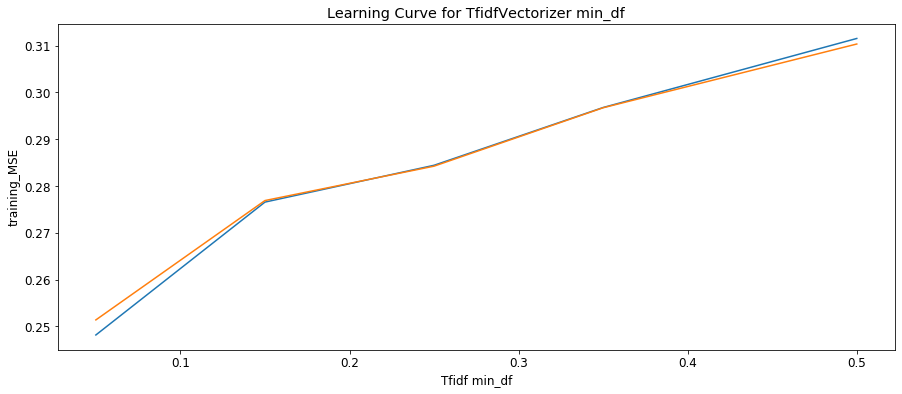

In [73]:
fig, ax = plt.subplots(figsize=(15,6))
plt.rcParams.update({'font.size': 12})
ax = sns.lineplot(x=tfidf_gs_df.x[5:10], y=tfidf_gs_df.training_MSE[5:10])
ax = sns.lineplot(x=tfidf_gs_df.x[5:10], y=tfidf_gs_df.validation_MSE[5:10])
ax.set(xlabel='Tfidf min_df', title="Learning Curve for TfidfVectorizer min_df")
plt.show()

In [39]:
def create_residualsdf(ypred):
    
    preds_df = pd.DataFrame(ypred, columns=['pred_score'])
    ytest_df = pd.DataFrame(y_test.values, columns=['test_score'])
    predtest_df = ytest_df.join(preds_df)
    newdf = X.join(predtest_df, how='right')
    newdf['residuals'] = newdf['test_score'] - newdf['pred_score']
    newdf = newdf.reindex(newdf.residuals.abs().sort_values(ascending=False).index)

    return newdf

In [40]:
lr_residualsdf = create_residualsdf(lr_y_pred)
print(lr_residualsdf.shape)
lr_residualsdf.head()

(6552, 11)


,Division,Type,Comment.Text.Processed,text_clean,char_count,avg_word_length,avg_sentence_length,caps_vs_length,test_score,pred_score,residuals
3891,MUSPERF,REC,I think this class should be required for seve...,think class required several semester performi...,1373.0,4.531353,14.428571,0.904762,1.00,4.417691,-3.417691
1427,ECON,DIS,[--] liked to had hour and half discussions so...,liked hour half discussion time discus previou...,1184.0,4.183746,21.769231,2.923077,1.00,3.959543,-2.959543
1027,MATH,LEC,"[--] a lot , did not explain material well at ...",lot explain material well professor explained ...,4033.0,4.119510,19.196078,1.431373,1.40,4.054047,-2.654047
1287,ENSCEN,LEC,[--] were off topic from the material . I enjo...,topic material enjoyed coming class learning b...,670.0,4.466667,16.666667,1.333333,1.67,4.097400,-2.427400
1004,MATH,LEC,[--] was just really hard to comprehend . He d...,really hard comprehend great job example tryin...,118.0,3.933333,10.000000,0.333333,2.25,4.585908,-2.335908


[Text(0, 0.5, 'Predicted'),
 Text(0.5, 0, 'Actual'),
 Text(0.5, 1.0, 'Actual vs Predicted Plot')]

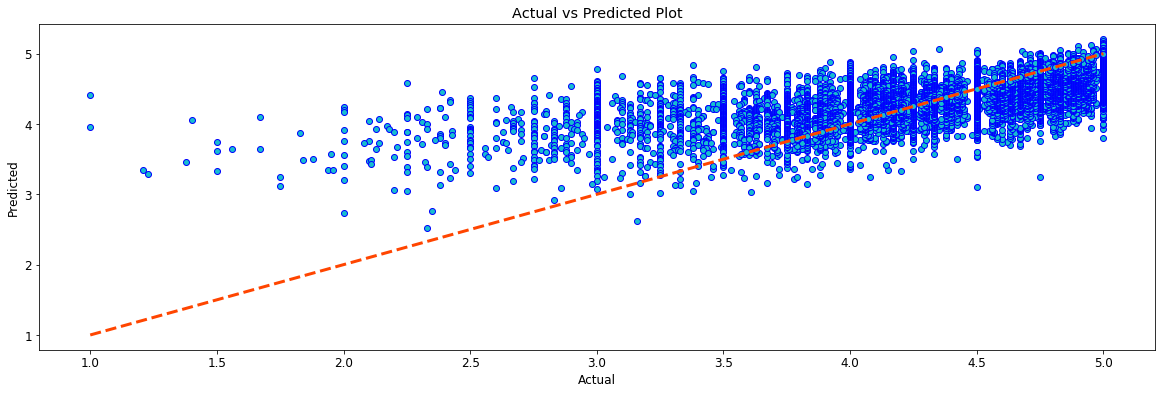

In [41]:
fig, ax = plt.subplots(figsize=(20,6))
plt.rcParams.update({'font.size': 12})
ax.scatter(lr_residualsdf.test_score, lr_residualsdf.pred_score, edgecolors=(0, 0, 1), c='tab:cyan')
ax.plot([lr_residualsdf.test_score.min(), lr_residualsdf.test_score.max()], 
        [lr_residualsdf.test_score.min(), lr_residualsdf.test_score.max()], 'k--', lw=3, color='orangered')
ax.set(xlabel="Actual", ylabel="Predicted", title="Actual vs Predicted Plot")

[Text(0, 0.5, 'Residuals'),
 Text(0.5, 0, 'Predicted'),
 Text(0.5, 1.0, 'Residual Plot')]

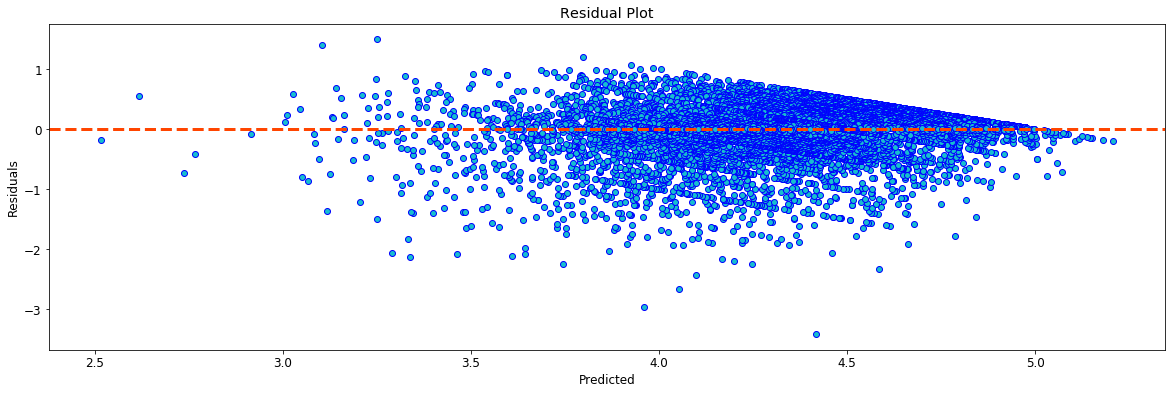

In [42]:
fig, ax = plt.subplots(figsize=(20,6))
plt.rcParams.update({'font.size': 12})
ax.scatter(lr_residualsdf.pred_score, lr_residualsdf.residuals, edgecolors=(0, 0, 1), c='tab:cyan')
ax.axhline(linewidth=3, linestyle='--', color='orangered')
ax.set(xlabel="Predicted", ylabel="Residuals", title="Residual Plot")

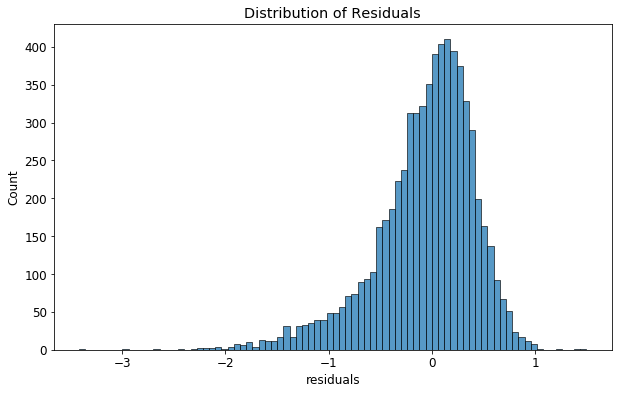

In [43]:
fig, ax = plt.subplots(figsize=(10,6))
plt.rcParams.update({'font.size': 12})
ax = sns.histplot(data=lr_residualsdf, x="residuals")
ax.set(xlabel="residuals", title="Distribution of Residuals")
plt.show()

In [44]:
feature_importances = lr_model_fitted.regressor_.coef_

In [45]:
cat_encoder =col_transform.transformers_[1][1]
txt_encoder = col_transform.transformers_[2][1]
# poly_encoder = full_pipeline.named_transformers_["num"]
# # poly_attribs = list(poly_encoder[0].get_feature_names(num_attribs))
cat_one_hot_attribs = list(cat_encoder.get_feature_names())
txt_vect_attribs = list(txt_encoder.get_feature_names())

attributes = num_features + cat_one_hot_attribs + txt_vect_attribs

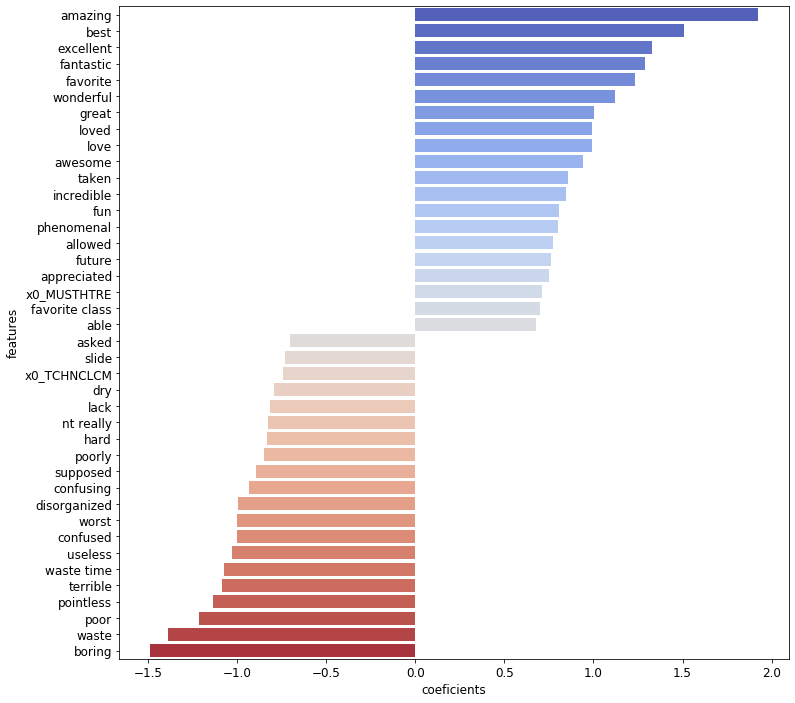

In [46]:
top20 = sorted(zip(feature_importances, attributes), reverse=True)[:20]
bot20 = sorted(zip(feature_importances, attributes), reverse=True)[-20:]
feat = pd.DataFrame(top20 + bot20, columns=['coeficients', 'features'])

fig, ax = plt.subplots(figsize=(12,12))
plt.rcParams.update({'font.size': 12})
ax = sns.barplot(y="features", x='coeficients', data=feat, palette='coolwarm')
plt.show()

In [ ]:
n_pipe = Pipeline([("robust", RobustScaler()),
                   ("power", PowerTransformer(standardize=True))])

pipelines = {}
for f in all_features:

    if f == 'text_clean':
#         print(f)
        pipe = ([("num", n_pipe, num_features),
                 ("cat", OneHotEncoder(categories='auto', handle_unknown='ignore'), cat_features)])
        
    if f in cat_features:
        new_cat = cat_features.copy()
        new_cat.remove(f)
#         print(new_cat)
        pipe = ([("num", n_pipe, num_features),
              ("cat", OneHotEncoder(categories='auto', handle_unknown='ignore'), new_cat),
              ("txt", TfidfVectorizer(stop_words='english', ngram_range=(1,3), max_features=25000, use_idf=False, norm='l2'), txt_features)])
        
    if f in num_features:
        new_num = num_features.copy()
        new_num.remove(f)
#         print(new_num)
        pipe = ([("num", n_pipe, new_num),
              ("cat", OneHotEncoder(categories='auto', handle_unknown='ignore'), cat_features),
              ("txt", TfidfVectorizer(stop_words='english', ngram_range=(1,3), max_features=25000, use_idf=False, norm='l2'), txt_features)])

    pipelines[f] = pipe

In [ ]:
def ablation_test(col, pipe, model):
    
    ablationscores = {}

    ab_X_train = X_train.drop(columns=[col])
    ab_X_test = X_test.drop(columns=[col])
    col_trans = ColumnTransformer(transformers=pipe)
    ab_X_train = col_trans.fit_transform(ab_X_train).toarray()
    ab_X_test = col_trans.transform(ab_X_test).toarray()

    reg_model = TransformedTargetRegressor(regressor=model, transformer=PowerTransformer(standardize=True))
    reg_model.fit(ab_X_train, y_train)
    y_pred = reg_model.predict(ab_X_test)
    ablationscores[col] = mean_squared_error(y_test, y_pred)
    
    return ablationscores

In [ ]:
ablationdict = {}
for f in all_features:
    ab = ablation_test(f, pipelines[f], lr_model)
    ablationdict[f] = ab


In [ ]:
bigram_pipe = ([("num", n_pipe, num_features),
              ("cat", OneHotEncoder(categories='auto', handle_unknown='ignore'), cat_features),
              ("txt", TfidfVectorizer(stop_words='english', ngram_range=(1,2), max_features=25000, use_idf=False, norm='l2'), txt_features)])
unigram_pipe = ([("num", n_pipe, num_features),
              ("cat", OneHotEncoder(categories='auto', handle_unknown='ignore'), cat_features),
              ("txt", TfidfVectorizer(stop_words='english', ngram_range=(1,1), max_features=25000, use_idf=False, norm='l2'), txt_features)])


